# Deep Learning Midterm Project

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import pickle
import csv
import random
import torch.nn.init as init

In [5]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) if torch.cuda.is_available() else None
random.seed(seed)
np.random.seed(seed)

In [6]:
# function fot loading batches
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [8]:
#The architecture below is based on the following pytorch tutorial:
#https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/
#https://arxiv.org/pdf/1512.03385.pdf

# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=1, bias=False)

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        #self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #out = self.dropout(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 16*4, layers[1], 2)
        self.layer3 = self.make_layer(block, 32*4, layers[2], 2)
        self.layer4 = self.make_layer(block, 64*4, layers[3], 2)
        self.avg_pool = nn.AvgPool2d(4)
        self.fc = nn.Linear(64*4, num_classes)
        #self.dropout = nn.Dropout(p=0.3)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        #out = self.dropout(out)
        out = self.fc(out)
        return out

# define resnet with 2,3,4,3 residual blocks 
model = ResNet(ResidualBlock, [2, 3, 4, 3]).to(device)

In [9]:
# overview of the model architecture
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
    ResidualBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

***The architecture has a total of 4.94M parameters. We specified the number of residual blocks in each layer, and the convolutional widths in each layer to reach close to the 5M parameter constraint to maximize the benefits of model size.***

In [10]:
# Dataset class for CIFAR-10 training batches
class CIFAR10Dataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # Load all data and labels from the batch files
        for file_path in file_paths:
            batch = load_cifar_batch(file_path)
            self.data.append(batch[b'data'])
            self.labels += batch[b'labels']

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to the correct format

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        img = img.astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, label

# Dataset class for testing batch
class CIFAR10TestDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = []
        self.labels = []
        self.transform = transform

        # Load all data from the test batch file
        batch = load_cifar_batch(file_path)
        self.data = batch[b'data']
        self.labels += batch[b'labels']
        self.data = self.data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to the correct format

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx], self.labels[idx]
        img = img.astype(np.uint8)

        if self.transform:
            img = self.transform(img)

        return img, label

In [11]:
# Transformations for train dataset
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(10),  
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Transformations for the test dataset
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
# Load CIFAR-10 dataset
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
cifar10_dataloader = torch.utils.data.DataLoader(cifar10_dataset, batch_size=100, shuffle=True)

cifar10_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
cifar10_test_dataloader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size=1000, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# function for updating the learning rate
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Initialize weights using Xavier initialization
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        init.xavier_uniform_(m.weight)

# Apply Xavier initialization to the model
model.apply(weights_init)

In [14]:
# function for training the model
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    correct = 0
    total = 0
    total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        # Calculate loss
        loss = criterion(output, target)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    average_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return accuracy, average_loss

In [ ]:
# function for evaluating accuracy
def evaluate_accuracy(model, device, criterion, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for batch_idx, (data, target) in enumerate(data_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate loss
            loss = criterion(output, target)
            total_loss += loss.item()
    
            # Calculate accuracy
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

        average_loss = total_loss / len(data_loader)
        accuracy = 100 * correct / total
    return accuracy, average_loss

In [15]:
# Define loss function and optimizer
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0005)
curr_lr = learning_rate
best_accuracy = 0

# containers for observed variables
val_losses, test_losses, val_accs, test_accs, lr_history = [], [], [], [], []

# Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# iterate over 100 epochs
for epoch in range(1, 101): 
    # training process
    train_acc, train_loss = train(model, device, cifar10_dataloader, criterion, optimizer, epoch)
    
    # validation process
    test_acc, test_loss = evaluate_accuracy(model, device, criterion, cifar10_test_dataloader)
    
    # print training loss and test accuracy
    print(f'Train Epoch: {epoch} \tTraining Loss: {train_loss:.4f} \tTesting Accuracy: {test_acc:.2f}%')
    
    # decrease epoch by a factor of 10 after 40 epochs (waterfall schedule)
    if epoch % 40 == 0:
        curr_lr = 0.1*curr_lr
        update_lr(optimizer, curr_lr)
        
    # save best model according to accuracy
    if test_acc > best_accuracy: 
        best_accuracy = test_acc
        torch.save(model.state_dict(), 'best-model-parameters-xavier-no_dropout.pt')
        
    # Store the metrics
    val_losses.append(train_loss)
    test_losses.append(test_loss)
    val_accs.append(train_acc)
    test_accs.append(test_acc)
    lr_history.append(curr_lr)

save_path = "/scratch/ne2213/projects/DL-FINAL/peter-initialize xavier/"

np.save(save_path + 'train_losses.npy', val_losses)
np.save(save_path + 'test_losses.npy', test_losses)
np.save(save_path + 'train_accs.npy', val_accs)
np.save(save_path + 'test_accs.npy', test_accs)
np.save(save_path + 'lr_history.npy', lr_history)

Train Epoch: 1 	Training Loss: 1.9082 	Testing Accuracy: 42.56%
Train Epoch: 2 	Training Loss: 1.3623 	Testing Accuracy: 60.16%
Train Epoch: 3 	Training Loss: 1.0079 	Testing Accuracy: 68.34%
Train Epoch: 4 	Training Loss: 0.7945 	Testing Accuracy: 73.80%
Train Epoch: 5 	Training Loss: 0.6958 	Testing Accuracy: 69.74%
Train Epoch: 6 	Training Loss: 0.6361 	Testing Accuracy: 77.23%
Train Epoch: 7 	Training Loss: 0.6018 	Testing Accuracy: 71.29%
Train Epoch: 8 	Training Loss: 0.5744 	Testing Accuracy: 76.75%
Train Epoch: 9 	Training Loss: 0.5510 	Testing Accuracy: 76.53%
Train Epoch: 10 	Training Loss: 0.5383 	Testing Accuracy: 78.06%
Train Epoch: 11 	Training Loss: 0.5189 	Testing Accuracy: 75.48%
Train Epoch: 12 	Training Loss: 0.5096 	Testing Accuracy: 75.50%
Train Epoch: 13 	Training Loss: 0.5004 	Testing Accuracy: 76.92%
Train Epoch: 14 	Training Loss: 0.4942 	Testing Accuracy: 77.48%
Train Epoch: 15 	Training Loss: 0.4827 	Testing Accuracy: 72.79%
Train Epoch: 16 	Training Loss: 0.

In [21]:
print('Maximum Accuracy on CIFAR-10 test dataset:',np.max(test_accs))

Maximum Accuracy on CIFAR-10 test dataset: 93.72


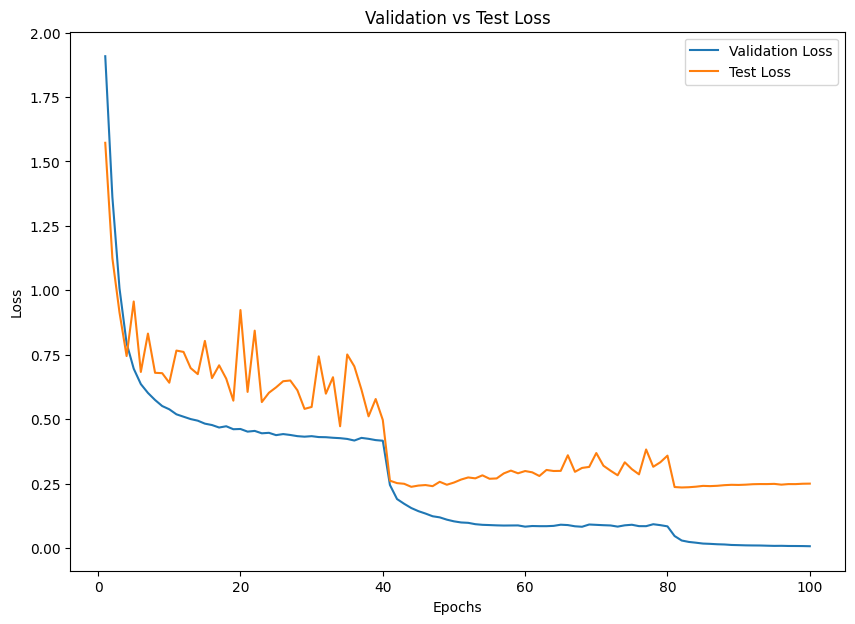

In [16]:
epochs = list(range(1, 101))

# Plot Validation vs Test Loss
plt.figure(figsize=(10, 7))
plt.plot(epochs, val_losses, label='Validation Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Validation vs Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

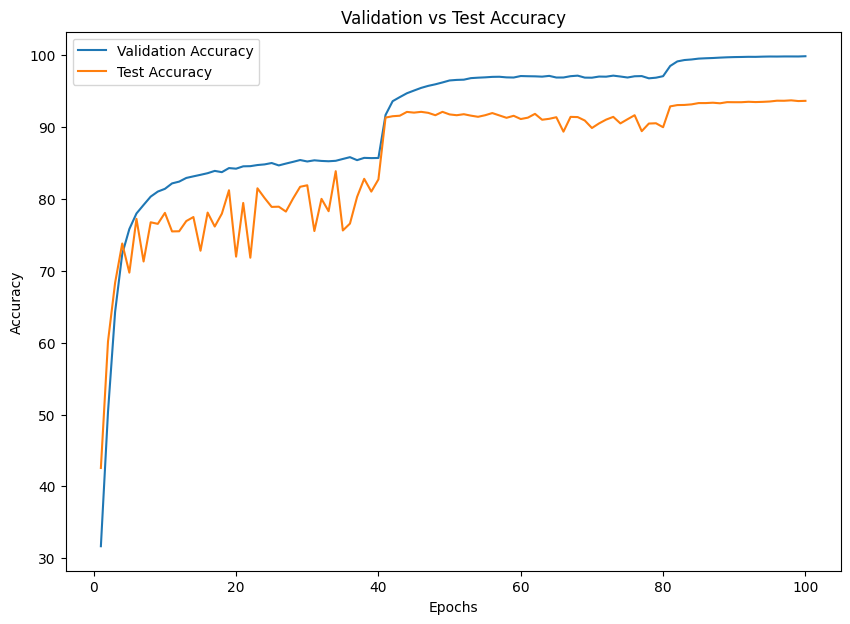

In [17]:
# Plot Validation vs Test Accuracy
plt.figure(figsize=(10, 7))
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title('Validation vs Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


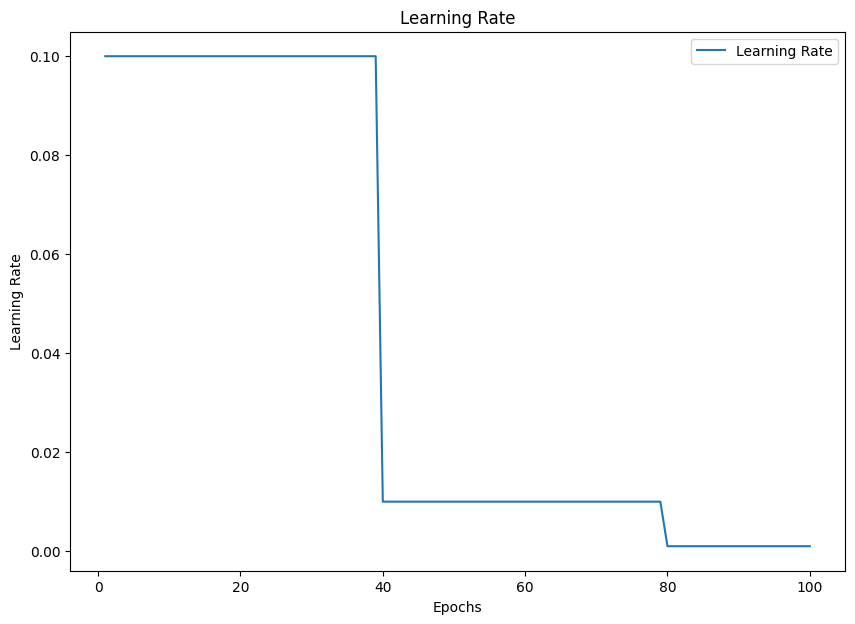

In [18]:
# Plot Learning Rate
plt.figure(figsize=(10, 7))
plt.plot(epochs, lr_history, label='Learning Rate')
plt.title('Learning Rate')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

In [ ]:
# Path to test batch
file_path = '/scratch/ne2213/projects/DL/cifar_test_nolabels.pkl'

# Initialize dataset and dataloader for the test dataset
test_dataset = CIFAR10TestDataset(file_path=file_path, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# evaluate on a test dataset, and collects the predicted labels
model.load_state_dict(torch.load('/scratch/ne2213/projects/DL-FINAL/peter-initialize xavier/regularization/best-model-parameters-xavier-regularized.pt'))
model.eval()  # Set the model to evaluation mode
predictions = []

with torch.no_grad():  # No need to track gradients
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

In [17]:
# Create and write the IDs and Labels to a CSV file
with open('/scratch/ne2213/projects/DL-FINAL/peter-initialize xavier/regularization/no_dropout.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["ID", "Labels"])  # Write the header

    # Write the predictions with IDs starting from 0
    for idx, label in enumerate(predictions):
        writer.writerow([idx, label])

print("Predictions saved to test.csv")

Predictions saved to test.csv
